<a href="https://colab.research.google.com/github/NengXu001/intro-to-RL-/blob/main/checkmate_learning_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment

In [249]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import time
from scipy.interpolate import make_interp_spline


size_board = 4

In [250]:
# initialize a seed for reproducing, you can use seed = 10
seed = int(time.time())
# seed = 10

In [251]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [252]:
## DEFINE THE EPSILON-GREEDY POLICY

def EpsilonGreedy_Policy(Qvalues,allowed_a,epsilon):
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon

    if rand_a == True:
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

    else:

        allowed_a = allowed_a.flatten()

        index = np.where(allowed_a == 1)[0]

        max = index[0]

        for i in index:
          if Qvalues[max] < Qvalues[i]:
            max = i

        a_agent = max
            
    return a_agent

In [253]:
# use adam for gradient descent
class Adam:

    def __init__(self, Params, beta1):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
            self.mt=np.zeros([self.N1])
            self.vt=np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.mt=np.zeros([self.N1,self.N2])
            self.vt=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta1=beta1
        self.beta2=0.999
        
        self.epsilon=10**(-8)
        
        # COUNTER OF THE TRAINING PROCESS
        self.counter=0
        
        
    def Compute(self,Grads):
                
        self.counter=self.counter+1
        
        self.mt=self.beta1*self.mt+(1-self.beta1)*Grads
        
        self.vt=self.beta2*self.vt+(1-self.beta2)*Grads**2
        
        mt_n=self.mt/(1-self.beta1**self.counter)
        vt_n=self.vt/(1-self.beta2**self.counter)
        
        New_grads=mt_n/(np.sqrt(vt_n)+self.epsilon)
        
        return New_grads

beta1=0.9 # First order momentum for Adam

In [254]:
# compute the exponential moving average
def ema(x,ema_eta):
  x = x.flatten()
  output = np.zeros(len(x))
  output[0] = x[0]
  for i in range(1,len(x)):
    output[i] = (1-ema_eta) * output[i-1] + ema_eta * x[i]

  return output

In [255]:
# INITIALISE THE PARAMETERS OF NEURAL NETWORK 
np.random.seed(seed)
S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

## INITALISE YOUR NEURAL NETWORK...
n_input_layer = N_in
n_hidden_layer = N_h
n_output_layer = N_a

np.random.seed(seed)
W1_ = np.random.randn(n_hidden_layer, n_input_layer) * np.sqrt(1 / (n_input_layer))
W2_ = np.random.randn(n_output_layer, n_hidden_layer) * np.sqrt(1 / (n_hidden_layer))

# Initialize the biases

b1 = np.zeros((n_hidden_layer,))
b2 = np.zeros((n_output_layer,))

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85     # THE DISCOUNT FACTOR 0.85
eta = 0.0003       # THE LEARNING RATE 0.0003

N_episodes = 40000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [256]:
def sarsa(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save_,N_moves_save_):

  # Using mask
  mask = np.zeros(N_a)

  #copy parameters of neurals
  W1 = np.copy(W1_)
  W2 = np.copy(W2_)
  bias_W1 = np.copy(b1)
  bias_W2 = np.copy(b2)

  Adam_W1=Adam(W1,beta1)
  Adam_W2=Adam(W2,beta1)  

  Adam_b1=Adam(bias_W1,beta1)
  Adam_b2=Adam(bias_W2,beta1)

  R_save = np.copy(R_save_)
  N_moves_save = np.copy(N_moves_save_)

  for n in range(N_episodes):

      epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
      Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
      i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
      
      S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

      h1 = np.dot(W1,X) + bias_W1

          # Apply the relu function
      x1 = (h1+abs(h1))/2

          # Neural activation: hidden layer -> output layer
      h2 = np.dot(W2,x1)+bias_W2

          # Apply the relu function
      x2 = (h2+abs(h2))/2

      Q_values = x2
        
      a_agent1 = EpsilonGreedy_Policy(Q_values , allowed_a, epsilon_f)
  
      while Done == 0:                           ## START THE EPISODE
          
          ##Q_values
          # Neural activation: input layer -> hidden layer
          h1 = np.dot(W1,X) + bias_W1

          # Apply the relu function
          x1 = (h1+abs(h1))/2

          # Neural activation: hidden lamyer -> output layer
          h2 = np.dot(W2,x1)+bias_W2

          # Apply the relu function
          x2 = (h2+abs(h2))/2

          Q_values = x2
        
          a_agent = a_agent1 
                  
          S_next, X_next, allowed_a_next, R,Done = env.OneStep(a_agent)
          
          ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
          if Done == 1:
              
              delta = R - Q_values[a_agent]
              mask_u = np.copy(mask)
              mask_u[a_agent] = delta

              # gradient of hidden --> ouput layer
              delta2 = mask_u * (1 * (h2 >=0))
              dbias_W2 = delta2

              # gradient of input --> hidden layer
              delta1 =  (1 * (h1 >=0)) * np.dot(W2.T, delta2)
              dbias_W1 = delta1

              W1 += eta * Adam_W1.Compute(np.outer(delta1, X)) 
              W2 += eta * Adam_W2.Compute(np.outer(delta2,x1))

              bias_W1 += eta *Adam_b1.Compute(dbias_W1) 
              bias_W2 += eta *Adam_b2.Compute(dbias_W2) 

              R_save[n]=np.copy(R)
              N_moves_save[n]=np.copy(i)

              break
            
          
          # IF THE EPISODE IS NOT OVER...
          else:

            h_next1 = np.dot(W1,X_next)+bias_W1

            # Apply the relu function
            x_next1 = (h_next1+abs(h_next1))/2

            # Neural activation: hidden layer -> output layer
            h_next2 = np.dot(W2,x_next1)+bias_W2

            # Apply the relu function
            x_next2 = (h_next2 +abs(h_next2))/2

            Q_values_next = x_next2

            a_agent1 = EpsilonGreedy_Policy(Q_values_next,allowed_a_next,epsilon_f)

            delta = gamma * Q_values_next[a_agent1] + R - Q_values[a_agent] 

            # gradient of hidden --> ouput layer
            mask_u = np.copy(mask)
            mask_u[a_agent] = delta

              # gradient of hidden --> ouput layer
            delta2 = mask_u * (1 * (h2 >=0))
            dbias_W2 = delta2

              # gradient of input --> hidden layer
            delta1 =  (1 * (h1 >=0)) * np.dot(W2.T, delta2)
            dbias_W1 = delta1

            W1 += eta * Adam_W1.Compute(np.outer(delta1, X)) 
            W2 += eta * Adam_W2.Compute(np.outer(delta2,x1))

            bias_W1 += eta *Adam_b1.Compute(dbias_W1) 
            bias_W2 += eta *Adam_b2.Compute(dbias_W2) 

      
          # NEXT STATE AND CO. BECOME ACTUAL STATE...     
          S=np.copy(S_next)
          X=np.copy(X_next)
          allowed_a=np.copy(allowed_a_next)
          
          i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
  return R_save,N_moves_save
      

In [257]:
def Q_learning(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save_,N_moves_save_):
## Using mask
 
  mask = np.zeros(N_a)

  W1 = np.copy(W1_)
  W2 = np.copy(W2_)
  bias_W1 = np.copy(b1)
  bias_W2 = np.copy(b2)

  Adam_W1=Adam(W1,beta1)
  Adam_W2=Adam(W2,beta1)  

  Adam_b1=Adam(bias_W1,beta1)
  Adam_b2=Adam(bias_W2,beta1)

  R_save = np.copy(R_save_)
  N_moves_save = np.copy(N_moves_save_)

  for n in range(N_episodes):

      epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
      Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
      i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
      
      S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
  
      while Done == 0:                           ## START THE EPISODE
          
          ##Q_values
          # Neural activation: input layer -> hidden layer
          h1 = np.dot(W1,X) + bias_W1

          # Apply the relu function
          x1 = (h1+abs(h1))/2

          # Neural activation: hidden layer -> output layer
          h2 = np.dot(W2,x1)+bias_W2

          # Apply the relu function
          x2 = (h2+abs(h2))/2

          Q_values = x2
        
          a_agent = EpsilonGreedy_Policy(Q_values , allowed_a, epsilon_f)
                  
          S_next, X_next, allowed_a_next, R,Done = env.OneStep(a_agent)
          
          ## THE EPISODE HAS ENDED, UPDATE W1,W2
          if Done == 1:
              
              delta = R - Q_values[a_agent]
              mask_u = np.copy(mask)
              mask_u[a_agent] = delta

              # gradient of hidden --> ouput layer
              delta2 = mask_u * (1 * (h2 >=0))
              dbias_W2 = delta2

              # gradient of input --> hidden layer
              delta1 =  (1 * (h1 >=0)) * np.dot(W2.T, delta2)
              dbias_W1 = delta1

              W1 += eta * Adam_W1.Compute(np.outer(delta1, X)) 
              W2 += eta * Adam_W2.Compute(np.outer(delta2,x1))

              bias_W1 += eta *Adam_b1.Compute(dbias_W1) 
              bias_W2 += eta *Adam_b2.Compute(dbias_W2) 

              R_save[n]=np.copy(R)
              N_moves_save[n]=np.copy(i)

              break
            
          
          # IF THE EPISODE IS NOT OVER...
          else:

            h_next1 = np.dot(W1,X_next)+bias_W1

            # Apply the relu function
            x_next1 = (h_next1+abs(h_next1))/2

            # Neural activation: hidden layer -> output layer
            h_next2 = np.dot(W2,x_next1)+bias_W2

            # Apply the relu function
            x_next2 = (h_next2 +abs(h_next2))/2

            Q_values_next = x_next2

            allowed_a_next_fla = allowed_a_next.flatten()

            Q_max = np.amax(Q_values_next[allowed_a_next_fla == 1])

            delta = gamma * Q_max + R - Q_values[a_agent] 

            # gradient of hidden --> ouput layer
            mask_u = np.copy(mask)
            mask_u[a_agent] = delta

              # gradient of hidden --> ouput layer
            delta2 = mask_u * (1 * (h2 >=0))
            dbias_W2 = delta2

              # gradient of input --> hidden layer
            delta1 =  (1 * (h1 >=0)) * np.dot(W2.T, delta2)
            dbias_W1 = delta1

            W1 += eta * Adam_W1.Compute(np.outer(delta1, X)) 
            W2 += eta * Adam_W2.Compute(np.outer(delta2, x1))

            bias_W1 += eta *Adam_b1.Compute(dbias_W1) 
            bias_W2 += eta *Adam_b2.Compute(dbias_W2) 
      
          # NEXT STATE AND CO. BECOME ACTUAL STATE...     
          S=np.copy(S_next)
          X=np.copy(X_next)
          allowed_a=np.copy(allowed_a_next)
          
          i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
  return R_save,N_moves_save

In [258]:
def plot_figure(save_):

  save = np.copy(save_)

  if save[0] == 0: #SARSA
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    plt.grid(None)
    axs[0].plot(ema(save[1],0.01))
    axs[0].set_title('Sarsa-R',fontsize = 20)
    axs[0].set_ylabel('Reward',fontsize = 14)
    axs[1].plot(ema(save[2],0.01))
    axs[1].set_title('Sarsa-N_moves',fontsize = 20)
    axs[1].set_ylabel('step_number',fontsize = 14)
    for ax in axs:
      ax.grid(b=True, which='major')
      ax.set_xlabel('Episodes',fontsize = 14)

  else: #Q_learning
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    plt.grid(None)
    axs[0].plot(ema(save[1],0.01))
    axs[0].set_title('Qlearning-R',fontsize = 20)
    axs[0].set_ylabel('Reward',fontsize = 14)
    axs[1].plot(ema(save[2],0.01))
    axs[1].set_title('Qlearning-N_moves',fontsize = 20)
    axs[1].set_ylabel('step_number',fontsize = 14)

    for ax in axs:
      ax.grid(b=True, which='major')
      ax.set_xlabel('Episodes',fontsize = 15)

  plt.show()

In [259]:
## compare sarsa/q_learning
def compare_figure(sarsa,Qlearning,ema_,episodes):

    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    
    plt.grid(None)
    axs[0].set_title('EMA Reward',fontsize = 20)
    axs[0].set_ylabel('Reward',fontsize = 15)
    axs[1].set_title('EMA moves',fontsize = 20)
    axs[1].set_ylabel('step_number',fontsize = 15)

    plt.figure()
    axs[0].plot(ema(sarsa[1][:episodes],ema_),label = 'sarsa',)
    axs[0].plot(ema(Qlearning[1][:episodes],ema_),label = 'Qlearning')
    axs[1].plot(ema(sarsa[2][:episodes],ema_),label = 'sarsa')
    axs[1].plot(ema(Qlearning[2][:episodes],ema_),label = 'Qlearning')

    for ax in axs:
      ax.legend(fontsize=14)
      ax.grid(b=True, which='major')
      ax.set_xlabel('Episodes',fontsize = 15)

In [260]:
# store sarsa and q_learning
sarsa_save = (0,) + sarsa(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save,N_moves_save)
Q_learning_save = (1,) + Q_learning(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save,N_moves_save)

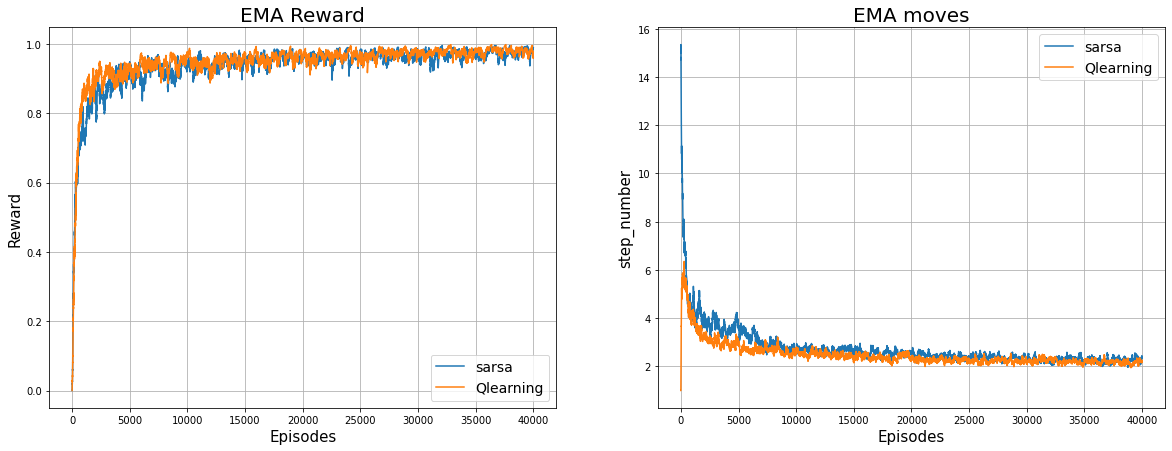

<Figure size 432x288 with 0 Axes>

In [261]:
compare_figure(sarsa_save,Q_learning_save,0.01,40000)

In [217]:
## store reward for different discount value
sarsa_end = []
Q_learning_end =[ ]
poss_gamma = np.linspace(0.7, 0.9, num=3)
for gamma in poss_gamma:
  sarsa_end.append(sarsa(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save,N_moves_save)[0]) 
  Q_learning_end.append(Q_learning(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save,N_moves_save)[0]) 

  # sarsa_save.append(sarsa(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save,N_moves_save))
  # Q_learning_save.append(Q_learning(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save,N_moves_save))

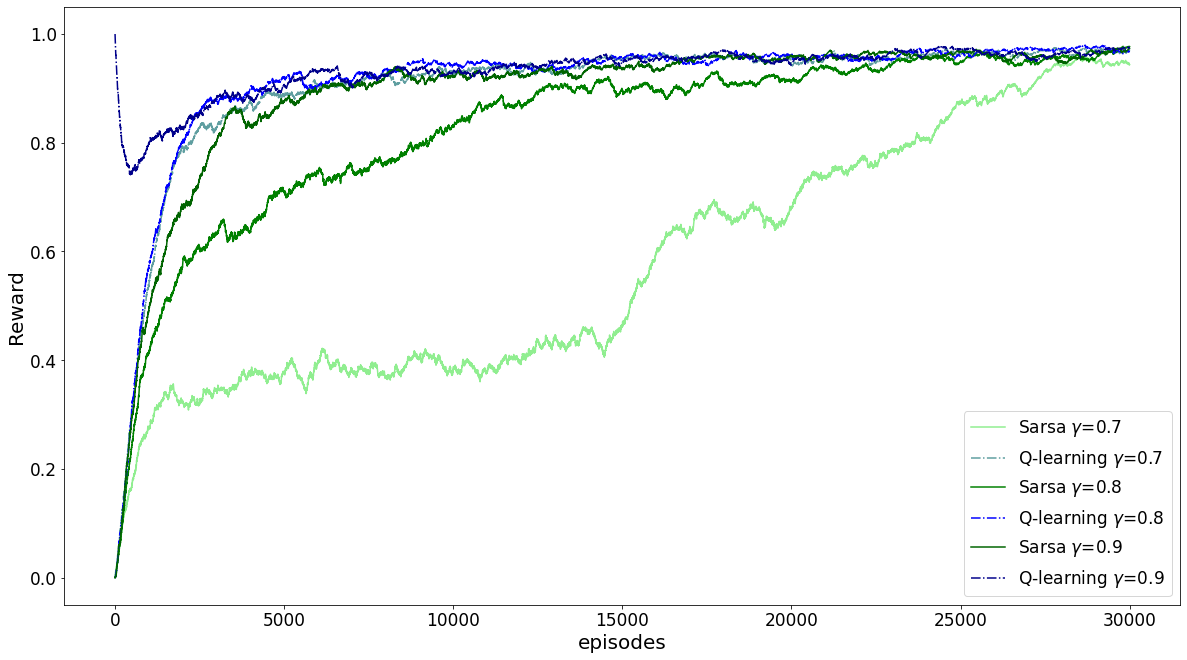

In [236]:
plt.figure(figsize=(20, 11))
sarsa_end1 = []
Q_learning_end1 = []
for i in range(len(poss_gamma)):
  sarsa_end1.append(ema(sarsa_end[i],0.002) ) 
  Q_learning_end1.append(ema(Q_learning_end[i],0.002) )
plt.plot( sarsa_end1[0], label=r'Sarsa $\gamma$=0.7',color = 'lightgreen')
plt.plot( Q_learning_end1[0] ,label =r'Q-learning $\gamma$=0.7',linestyle=  '-.',color = 'cadetblue')
plt.plot(sarsa_end1[1], label=r'Sarsa $\gamma$=0.8',color = 'green')
plt.plot( Q_learning_end1[1] ,label =r'Q-learning $\gamma$=0.8',linestyle=  '-.',color = 'blue')
plt.plot( sarsa_end1[2], label=r'Sarsa $\gamma$=0.9',color = 'darkgreen')
plt.plot( Q_learning_end1[2] ,label =r'Q-learning $\gamma$=0.9',linestyle=  '-.',color = 'darkblue')


plt.legend(fontsize = 17)
plt.xlabel('episodes',fontsize = 20)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.ylabel('Reward',fontsize = 20)
plt.show()

In [ ]:
sarsa_end = []
Q_learning_end =[]
poss_beta = np.linspace(0.0002,0.00001,num=10)
for beta in poss_beta:
  sarsa_end.append(sarsa(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save,N_moves_save)[0]) 
  Q_learning_end.append(Q_learning(W1_,W2_,b1,b2,epsilon_0,beta,gamma,R_save,N_moves_save)[0]) 

In [ ]:
plt.figure(figsize=(20, 11))
for i in range(len(poss_beta)):
  sarsa_end[i] = ema(sarsa_end[i],0.005) 
  Q_learning_end[i] = ema(Q_learning_end[i],0.01) 
plt.plot( sarsa_end[0], label=r'Sarsa $\beta$=0.0002')
plt.plot( Q_learning_end[0] ,label =r'Q-learning $\beta$=0.0002',linestyle=':')
plt.plot(sarsa_end[1], label=r'Sarsa $\beta$=0.0001')
plt.plot( Q_learning_end[1] ,label =r'Q-learning $\beta$=0.0001',linestyle=':')
plt.plot( sarsa_end[2], label=r'Sarsa $\beta$=0.00005')
plt.plot( Q_learning_end[2] ,label =r'Q-learning $\beta$=0.00005',linestyle=':')
plt.plot( sarsa_end[3], label=r'Sarsa $\beta$=0.000001')
plt.plot( Q_learning_end[3] ,label =r'Q-learning $\beta$=0.000001',linestyle=':')

plt.legend(fontsize = 13)
plt.xlabel('episodes',fontsize = 15)
plt.ylabel('Reward',fontsize = 15)
plt.show()

In [ ]:
plt.figure(figsize=(20, 11))
sarsa_reward = np.zeros(len(poss_beta))
qlearning_reward = np.zeros(len(poss_beta))
for i in range(len(poss_beta)):
  sarsa_reward[i] = np.mean(sarsa_end[i][-100:])
  qlearning_reward[i] = np.mean(Q_learning_end[i][-100:])

plt.plot(poss_beta,sarsa_reward,'bs-',label = 'Sarsa')
plt.plot(poss_beta,qlearning_reward,'g^-', label = 'Q_learning')
plt.legend()
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.xlabel(r'discount factor$\beta$',fontsize = 20)
plt.ylabel('Reward',fontsize = 20)
plt.show()

In [ ]:
## store  reward for different epsilon decaying speed


In [119]:
# # VANILLA GRADIENT DESCENT

# for n in range(N_episodes):

#     epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
#     Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
#     i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
#     S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
 
#     while Done == 0:                           ## START THE EPISODE
        
#         ##Q_values
#         # Neural activation: input layer -> hidden layer
#         h1 = np.dot(W1,X) + bias_W1

#         # Apply the relu function
#         x1 = (h1+abs(h1))/2

#         # Neural activation: hidden layer -> output layer
#         h2 = np.dot(W2,x1)+bias_W2

#         # Apply the relu function
#         x2 = (h2+abs(h2))/2

#         Q_values = x2
      
#         a_agent = EpsilonGreedy_Policy(Q_values , allowed_a, epsilon_f)
                
#         S_next, X_next, allowed_a_next, R,Done = env.OneStep(a_agent)
        
#         ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
#         if Done == 1:
            
#             delta = R - Q_values[a_agent]

#             # gradient of hidden --> ouput layer
#             dW2 = (1 * (h2[a_agent] >=0)) * x1
#             delta2 = delta * (1 * (h2[a_agent] >=0))
#             dbias_W2 = delta2

#             # gradient of input --> hidden layer
#             delta1 = delta2 * W2[a_agent,:] * (1 * (h1 >=0))
#             dbias_W1 = delta1

#             W1 +=  eta * np.outer(delta1 , X)
#             W2[a_agent,:] += eta * delta * dW2

#             bias_W1 += eta * dbias_W1
#             bias_W2[a_agent] += eta * dbias_W2

#             R_save[n]=np.copy(R)
#             N_moves_save[n]=np.copy(i)


#             break
           
        
#         # IF THE EPISODE IS NOT OVER...
#         else:

#           h_next1 = np.dot(W1,X_next)+bias_W1

#           # Apply the relu function
#           x_next1 = (h_next1+abs(h_next1))/2

#           # Neural activation: hidden layer -> output layer
#           h_next2 = np.dot(W2,x_next1)+bias_W2

#           # Apply the relu function
#           x_next2 = (h_next2 +abs(h_next2))/2

#           Q_values_next = x_next2

#           a_agent1 = EpsilonGreedy_Policy(Q_values_next,allowed_a_next,epsilon_f)

#           delta = gamma * Q_values_next[a_agent1] + R - Q_values[a_agent] 

#           # gradient of hidden --> ouput layer
#           dW2 = (1 * (h2[a_agent] >=0)) * x1
#           delta2 = delta * (1 * (h2[a_agent] >=0))
#           dbias_W2 = delta2

#           # gradient of input --> hidden layer
#           delta1 = delta2 * W2[a_agent,:] * (1 * (h1 >=0))
#           dbias_W1 = delta1

#           W1 +=  eta * np.outer(delta1, X)
#           W2[a_agent,:] += eta * delta * dW2

#           bias_W1 += eta * dbias_W1
#           bias_W2[a_agent] += eta * dbias_W2
          
     
#         # NEXT STATE AND CO. BECOME ACTUAL STATE...     
#         S=np.copy(S_next)
#         X=np.copy(X_next)
#         allowed_a=np.copy(allowed_a_next)
        
#         i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    

In [120]:
## using the mean of the last n episodes to plot
# def Mean(x):
#     x = [0] + x
#     m = [0 for _ in range(len(x))]  
#     for i in range(1, len(x)):
#         m[i] = ((i - 1) * m[i - 1] + x[i]) / i
#     m= m[1:]
#     return m